In [22]:
import warnings
warnings.filterwarnings('ignore')

Viewing solar data with SunPy
---
In the first half of this tutorial, we'll look at how to search for, download, and plot remote sensing data using SunPy.

Setting search parameters
---
In order to search for some data, we have to select a time range and an instrument to search for. In addition, here we also specify the wavelength of interest.

In [1]:
from sunpy.net import Fido, attrs as a
import astropy.units as u

Searching for data
---
Using the above defined search parameters, Fido can be used to search for data. For more information on searching for and downloading data see https://docs.sunpy.org/en/stable/guide/acquiring_data/index.html

In [2]:
result = Fido.search(a.Time('2018/10/31 14:00', '2018/10/31 19:00'),
                     a.Instrument('AIA'),
                     a.Wavelength(19.3 * u.nm),
                     a.Sample(1*u.hour))
result

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2018-10-31 16:00:04,2018-10-31 16:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2018-10-31 14:00:04,2018-10-31 14:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2018-10-31 15:00:04,2018-10-31 15:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2018-10-31 17:00:04,2018-10-31 17:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2018-10-31 18:00:04,2018-10-31 18:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0


Downloading data
---
The results from a search can also be downloaded. The above 'results' object can be indexed like an array. The first index is for the data provider, and the second index selects the row of interest. In this example we just download the first iamge from the first provider, so use ``results[0, 0]``.

``Fido.fetch`` returns a list of the local location of the downloaded files.

In [3]:
downloaded_files = Fido.fetch(result)
print(downloaded_files)


['/home/stuart/sunpy/data/aia_lev1_193a_2018_10_31t15_00_04_84z_image_lev1.fits', '/home/stuart/sunpy/data/aia_lev1_193a_2018_10_31t16_00_04_84z_image_lev1.fits', '/home/stuart/sunpy/data/aia_lev1_193a_2018_10_31t17_00_04_84z_image_lev1.fits', '/home/stuart/sunpy/data/aia_lev1_193a_2018_10_31t14_00_04_85z_image_lev1.fits', '/home/stuart/sunpy/data/aia_lev1_193a_2018_10_31t18_00_04_84z_image_lev1.fits']


Loading and plotting data
---
Now we have downloaded some data, we can load it and plot it. ``sunpy.map.Map`` can be used to load any ``.fits`` file, creating a ``Map`` object. We can then take a look at the image stored by calling ``map.peek()``.

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sunpy.map

<IPython.core.display.Javascript object>


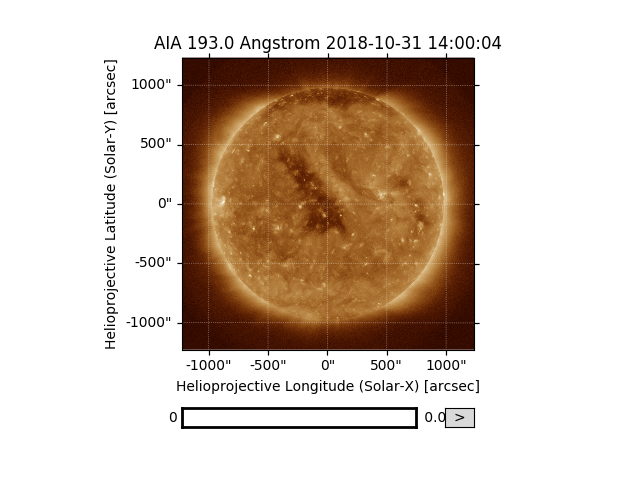

In [5]:
map_seq = sunpy.map.Map(downloaded_files, sequence=True)
map_seq.peek()

<IPython.core.display.Javascript object>


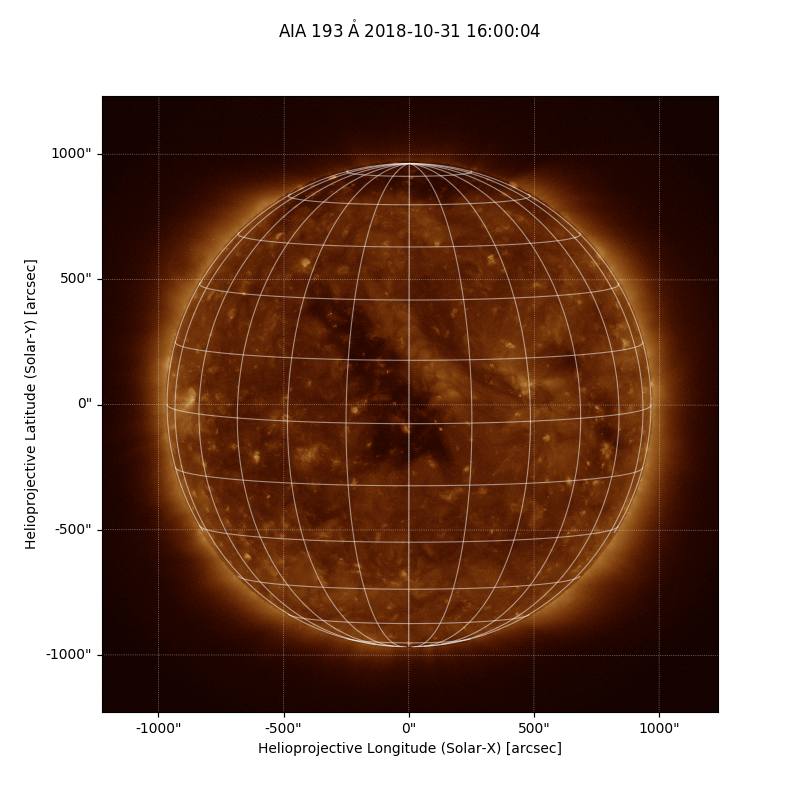

In [6]:
aiamap = map_seq[2]
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=aiamap)
aiamap.plot(ax)
aiamap.draw_grid()

Identifying a coronal hole
---
In the above AIA 193 image, there is a dark patch in the middle of the disc. This is a coronal hole, which is the source of the fastest solar wind.

This observation can be connected to in-situ measurements of the solar wind at 1 AU by looking for the fast solar wind stream that emmenates from this coronal hole. Because the solar wind takes a finite amount of time to propagate from the Sun to Earth, we first do an order of magnitude estimate of this delay.

Using astropy units
---
To calculate the propagation delay we can use the ``astropy.units`` module. This provides an extension of normal numbers and arrays, and allows units to be attached. All the unit mathematics is calculated automatically, avoiding the need to keep track of specific units.

In [7]:
import astropy.constants as const
from sunpy.coordinates.ephemeris import get_earth

Assume the solar wind is relesed from the surface of the Sun, so the propagation distance is $D_{sun} - R_{sun}$

In [8]:
d_sun = get_earth(aiamap.date)
d_sun

<SkyCoord (HeliographicStonyhurst: obstime=2018-10-31T16:00:04.840): (lon, lat, radius) in (deg, deg, AU)
    (0., 4.44005377, 0.99272415)>

In [9]:
d = (d_sun.radius - const.R_sun)

Take a typical fast solar wind speed of 500 km/s

In [10]:
vsw = 500 * u.km / u.s

Calculate tne propagation time, and convert it to units of days

In [11]:
t = (d / vsw).to(u.d)
t

<Quantity 3.42161386 d>

In [12]:
estimated_arrival = aiamap.date + t
estimated_arrival

<Time object: scale='utc' format='isot' value=2018-11-04T02:07:12.278>

Downloading and importing in-situ data
---
The ``heliopy.data`` module can be used to download and import a wide range of in situ datasets from various heliospheric missions. In this example we use data from OMNI, which provides measurements of the solar wind at the orbit of the Earth.

In [13]:
from heliopy.data import omni
from datetime import datetime

In [14]:
starttime = aiamap.date - (1*u.year / 12)
endtime = aiamap.date + (1*u.year / 12)
data = omni.low(starttime.datetime, endtime.datetime)

The data is stored in the ``data`` object. We can print the available columns in this object:

In [15]:
data.meta

|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2018-10-01 06:00:00        | Bartels Rotatio |                                                   |
|            to             | ID IMF Spacecra |                                                   |
|2018-12-01 02:00:00        | ID SW Plasma Sp |                                                   |
|                           | points(IMF Aver |                                                   |
|                           | points(Plasma A |                                                   |
|                           | |B|             |                                                   |
|                           | Magnitude of Av |                                                   |


In [16]:
for col in data.columns:
    print(col)

Bartels Rotation Number
ID IMF Spacecraft
ID SW Plasma Spacecraft
points(IMF Average)
points(Plasma Average)
|B|
Magnitude of Avg Field Vector
Lat. Angle of Aver. Field Vector
Long. Angle of Aver. Field Vector
Bx GSE, GSM
By GSE
Bz GSE
By GSM
Bz GSM
sigma |B|
sigma B
sigma Bx
sigma By
sigma Bz
Proton Temperature
Proton Density
Plasma Flow Speed
Plasma Flow Long. Angle
Plasma Flow Lat. Angle
Na/Np
Flow Pressure
sigma T
sigma N
sigma V
sigma phi V
sigma theta V
sigma Na/Np
Electric Field
Plasma Beta
Alfven Mach Number
Kp
R
DST Index
AE Index
Proton Flux > 1MeV
Proton Flux > 2MeV
Proton Flux > 4MeV
Proton Flux > 10MeV
Proton Flux > 30MeV
Proton Flux > 60MeV
flag
ap index
f10.7 index
PC(N) index
AL index (Kyoto)
AU index (Kyoto)
Magnetosonic Mach No.


Plotting in-situ data
---
Matplotlib can be used to plot the downloaded data. In this example we plot the solar wind speed and the magnetic field clock angle, to see different polarity solar wind streams.

We also add a vertical line where the stream is fast stream is predicted to have arrived using the above back-of-the-envelope calculate. We can see that it lines up nicely with a fast solar wind stream that has speeds of 500 - 600 km/s.

In [17]:
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fbfd3b35e50>

<IPython.core.display.Javascript object>


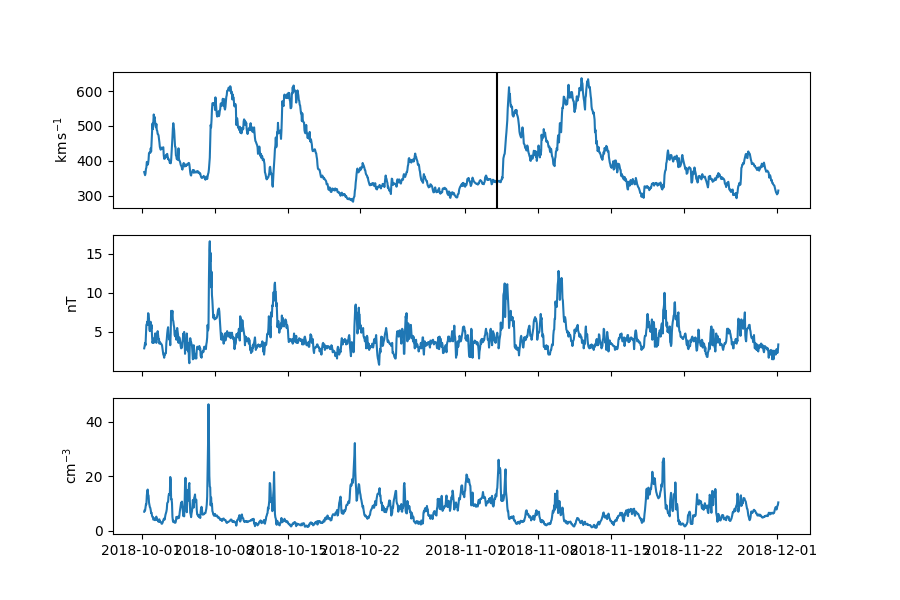

In [21]:
fig, axs = plt.subplots(figsize=(9, 6), nrows=3, sharex=True)

ax = axs[0]
ax.plot(data.index, data.quantity('Plasma Flow Speed'), label='$v_{sw}$')
ax.axvline(estimated_arrival.datetime, color='k')

ax = axs[1]
ax.plot(data.index, data.quantity('|B|'), label='$|B|$')

ax = axs[2]
ax.plot(data.index, data.quantity('Proton Density'), label='$n_{p}$')

Improving figure formatting
---

<IPython.core.display.Javascript object>


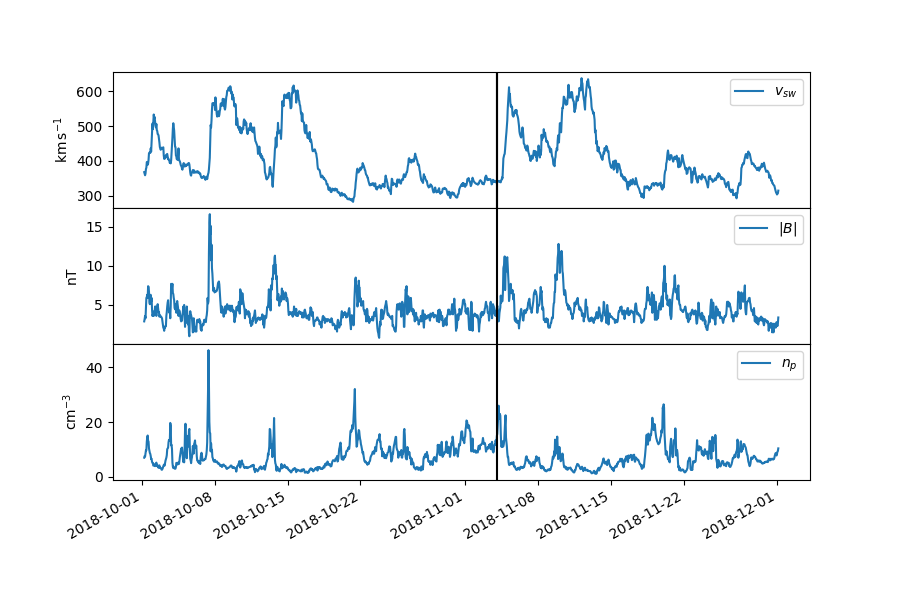

In [19]:
# Make the x-axis formatting nicer
fig.autofmt_xdate()
fig.subplots_adjust(hspace=0)

# Add a legend to each axes
for ax in axs:
    ax.legend()
    ax.axvline(estimated_arrival.datetime, color='k')

# Show the figure again
fig

Save a copy of the figure
---

In [20]:
fig.savefig('tseries.pdf', bbox_inches='tight')